<a href="https://colab.research.google.com/github/alessandrossC/ML-for-people/blob/main/%22HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/edce80b5bb02479085855b2334b17fc1). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [1]:
!pip install opendatasets

In [22]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
od.download('https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data?select=sample_submission.csv')
od.download('https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data?select=test.csv')
od.download('https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data?select=train.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: oleksandrchekoi
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 79.5MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-2/bank-customer-churn-prediction-dlu-course-c-2.zip to ./bank-customer-churn-prediction-dlu-course-c-2
Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu-course-c-2" (use force=True to force download)
Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu-course-c-2" (use force=True to force download)


Area under ROC score on Train dataset: 0.90%


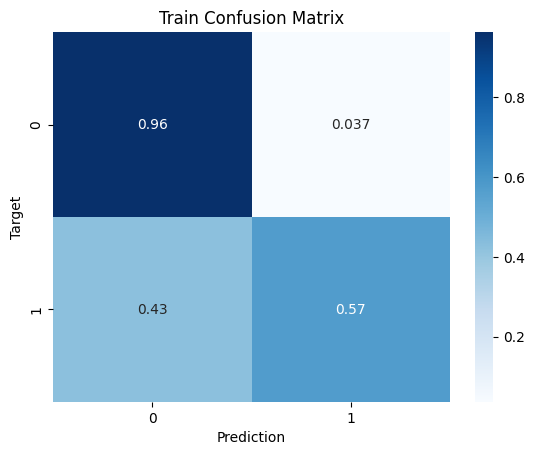

Area under ROC score on Test dataset: 0.88%


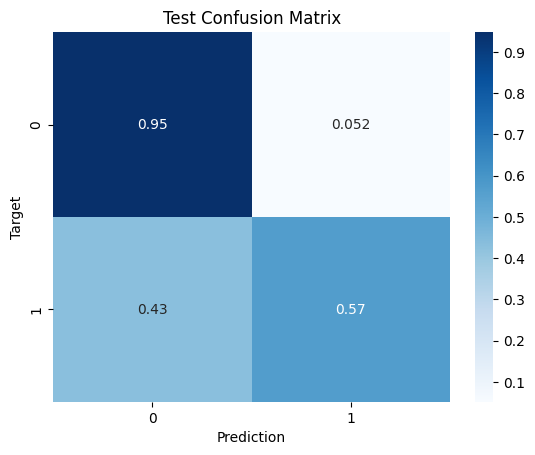

['sample_submission1.joblib']

In [28]:
raw_df = pd.read_csv('/content/bank-customer-churn-prediction-dlu-course-c-2/train.csv', index_col=0)
target_col = 'Exited'

train_df, val_df = train_test_split(raw_df,
    test_size=0.2,
    stratify=raw_df[target_col],
    random_state=42)

# Створюємо трен. і вал. набори
input_cols = [col for col in raw_df.columns if col != 'Exited']

train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    roc_auc = roc_auc_score(targets, model_pipeline.predict_proba(inputs)[:, 1])
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name="Train")
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name="Test")

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'sample_submission1.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train dataset: 0.93%


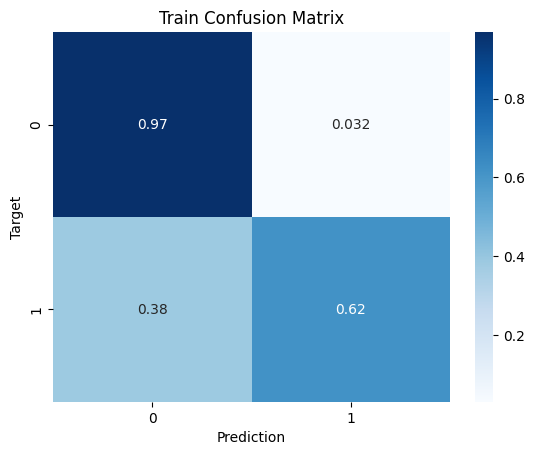

Area under ROC score on Validation dataset: 0.91%


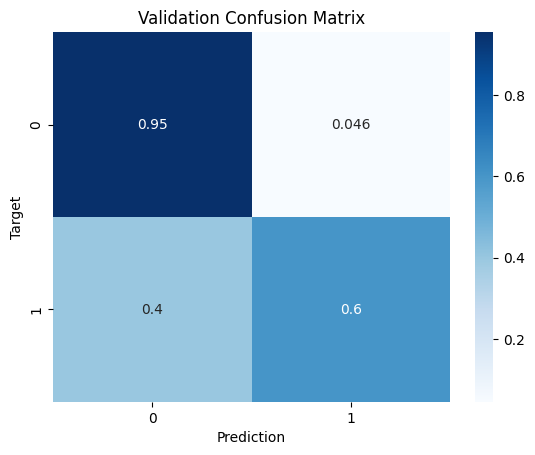

['sample_submission2.joblib']

In [29]:
from sklearn.preprocessing import PolynomialFeatures

# Створюємо новий трансформер для числових ознак, який включає PolynomialFeatures
numeric_transformer_poly = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Генерація поліноміальних ознак до 2-го степеня
    ('scaler', MinMaxScaler())  # Масштабування ознак
])

# Оновлений ColumnTransformer, який враховує нові числові ознаки
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Оновлений пайплайн з Logistic Regression
model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Тренуємо оновлений пайплайн
model_pipeline_poly.fit(train_inputs, train_targets)

# Оцінюємо модель на тренувальних та валідаційних даних
train_preds_poly = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, name="Train")
val_preds_poly = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, name="Validation")

# Збереження нової моделі
joblib.dump(model_pipeline, 'sample_submission2.joblib')

Немає сильного overfit – модель добре узагальнює.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train dataset: 0.94%


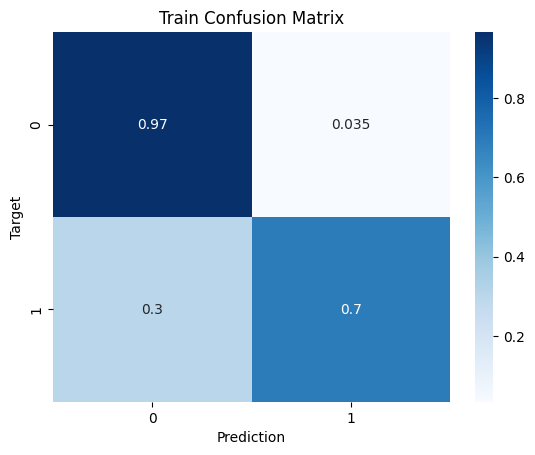

Area under ROC score on Validation dataset: 0.93%


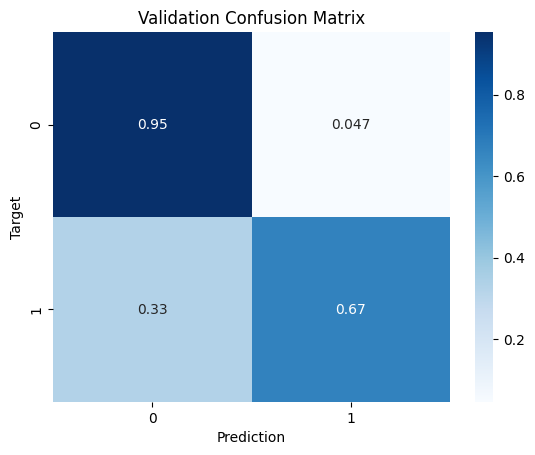

['sample_submission4.joblib']

In [30]:
# Створюємо новий трансформер для числових ознак, який включає PolynomialFeatures (ступінь 4)
numeric_transformer_poly4 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),  # Генерація поліноміальних ознак до 4-го степеня
    ('scaler', MinMaxScaler())  # Масштабування ознак
])

# Оновлений ColumnTransformer, який враховує нові числові ознаки
preprocessor_poly4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Оновлений пайплайн з Logistic Regression
model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Тренуємо оновлений пайплайн
model_pipeline_poly4.fit(train_inputs, train_targets)

# Оцінюємо модель на тренувальних та валідаційних даних
train_preds_poly4 = predict_and_plot(model_pipeline_poly4, train_inputs, train_targets, name="Train")
val_preds_poly4 = predict_and_plot(model_pipeline_poly4, val_inputs, val_targets, name="Validation")

# Збереження нової моделі
joblib.dump(model_pipeline, 'sample_submission4.joblib')


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Завантаження даних
regression_df = pd.read_csv ('/content/regression_data.csv')

# Визначення цільової змінної та вхідних ознак
target_col = 'target'
input_cols = [col for col in regression_df.columns if col != target_col]

# Поділ на тренувальний та тестовий набір
train_df, test_df = train_test_split(regression_df, test_size=0.2, random_state=42)

# Визначаємо числові колонки
numeric_cols = train_df[input_cols].select_dtypes(include=np.number).columns.tolist()

# Формуємо train та test
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
test_inputs, test_targets = test_df[input_cols].copy(), test_df[target_col].copy()

# Створюємо трансформер для числових ознак, який включає PolynomialFeatures (ступінь 5)
numeric_transformer_poly5 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),  # Поліноміальні ознаки до 5-го степеня
    ('scaler', MinMaxScaler())  # Масштабування ознак
])

# Оновлений ColumnTransformer
preprocessor_poly5 = ColumnTransformer(
    transformers=[('num', numeric_transformer_poly5, numeric_cols)])

# Пайплайн моделі Лінійної регресії
model_pipeline_poly5 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly5),
    ('regressor', LinearRegression())
])

# Навчання моделі
model_pipeline_poly5.fit(train_inputs, train_targets)

# Передбачення
train_preds = model_pipeline_poly5.predict(train_inputs)
test_preds = model_pipeline_poly5.predict(test_inputs)

# Оцінка якості моделі
train_mae = mean_absolute_error(train_targets, train_preds)
test_mae = mean_absolute_error(test_targets, test_preds)

train_rmse = np.sqrt(mean_squared_error(train_targets, train_preds))
test_rmse = np.sqrt(mean_squared_error(test_targets, test_preds))

train_r2 = r2_score(train_targets, train_preds)
test_r2 = r2_score(test_targets, test_preds)

# Вивід метрик
{
    "Train MAE": train_mae,
    "Test MAE": test_mae,
    "Train RMSE": train_rmse,
    "Test RMSE": test_rmse,
    "Train R2": train_r2,
    "Test R2": test_r2
}


{'Train MAE': 1.069177109306976e-13,
 'Test MAE': 6.87856909115895,
 'Train RMSE': 1.498012525636353e-13,
 'Test RMSE': 12.363286870575426,
 'Train R2': 1.0,
 'Test R2': 0.9344849674479442}

Train R² = 1.0 - Модель ідеально підлаштувалася під тренувальні дані.
Test R² = 0.93 - Модель добре узагальнює, але є невеликий спад точності.

Велика різниця між Train MAE (≈0) і Test MAE (6.88) свідчить про перенавчання

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [39]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

# Поліноміальні ознаки до 20-го степеня
numeric_transformer_poly20 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=20, include_bias=False)),  # Генерація ознак до 20-го степеня
    ('scaler', MinMaxScaler())  # Масштабування
])

# Оновлений препроцесор
preprocessor_poly20 = ColumnTransformer(
    transformers=[('num', numeric_transformer_poly20, numeric_cols)])

# Функція для тренування та оцінки моделі
def train_and_evaluate(model, name):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_poly20),
        ('regressor', model)
    ])

    # Навчання моделі
    pipeline.fit(train_inputs, train_targets)

    # Передбачення
    train_preds = pipeline.predict(train_inputs)
    test_preds = pipeline.predict(test_inputs)

    # Оцінка метрик
    metrics = {
        "Model": name,
        "Train MAE": mean_absolute_error(train_targets, train_preds),
        "Test MAE": mean_absolute_error(test_targets, test_preds),
        "Train RMSE": np.sqrt(mean_squared_error(train_targets, train_preds)),
        "Test RMSE": np.sqrt(mean_squared_error(test_targets, test_preds)),
        "Train R2": r2_score(train_targets, train_preds),
        "Test R2": r2_score(test_targets, test_preds)
    }
    return metrics

# Запуск тренування для кожної моделі
lasso_metrics = train_and_evaluate(Lasso(alpha=0.1, max_iter=10000), "Lasso Regression")
ridge_metrics = train_and_evaluate(Ridge(alpha=1.0), "Ridge Regression")
elasticnet_metrics = train_and_evaluate(ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000), "ElasticNet Regression")

# Виведення результатів
results = pd.DataFrame([lasso_metrics, ridge_metrics, elasticnet_metrics])
print(results)


                   Model  Train MAE   Test MAE  Train RMSE   Test RMSE  \
0       Lasso Regression   0.949972   0.834092    1.198566    1.004574   
1       Ridge Regression   5.687438  25.178633    8.597750   76.562708   
2  ElasticNet Regression  14.324695  42.601066   18.810003  124.929194   

   Train R2   Test R2  
0  0.999262  0.999567  
1  0.962049 -1.512509  
2  0.818354 -5.689612  


Lasso Regression – найкраща модель!

Test R² = 0.999 → Модель чудово узагальнює дані.
Test RMSE = 1.00 (найменше серед всіх).
Lasso добре підходить для боротьби з Overfitting, бо зменшує коефіцієнти ознак.
Ridge та ElasticNet погано генералізують

Ridge Regression має Train R² = 0.96, але Test R² = -1.51 - сильний Overfitting.
ElasticNet Regression взагалі має Test R² = -5.69, що означає, що модель абсолютно непридатна.